# <span style="color:red">Mall Customer Segmentation Using Unsupervised Learning</span>

## 1. Introduction

In today's competitive market, customer segmentation has become crucial. Segmenting customers allows businesses to personalize marketing, improve retention, and understand different customer behaviors. This project uses the Mall Customers dataset to segment customers based on spending behavior and demographics.

We will use various Unsupervised Learning models, perform exploratory data analysis, and compare different clustering methods to achieve the best segmentation.

## 2. Gather Data and Discuss Data Provenance

Dataset: Mall Customer Segmentation Data  
Source: Kaggle Dataset (https://www.kaggle.com/datasets/abdallahwagih/mall-customers-segmentation/data)  
Method: Publicly available open dataset uploaded by Kaggle user.  
Provenance: Data collected by a mall to track customer demographics and spending scores.


## 3. Data Description

The Mall Customers dataset contains 200 observations across the following features:
 - CustomerID: Unique identifier for each customer (not used for clustering)
 - Gender: Gender of the customer (Male/Female)
 - Age: Age of the customer (integer, from 18 to 70)
 - Annual Income (k$): Annual income of the customer in thousands of dollars (integer, 15-137)
 - Spending Score (1-100): Score assigned by the mall based on customer spending behavior

## 4. Imports & Setup

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, LabelEncoder
warnings.filterwarnings('ignore')

## 5. Exploratory Data Analysis (EDA)

**5.1 Data Inspection**

First, we load and inspect the dataset:

In [78]:
# Load Dataset
df = pd.read_csv('Mall_Customers.csv')

# Overview
print(df.head())
print(df.info())
print(df.describe())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  

Initial Observations:

Rows: 200 samples.

Columns (Features):

       - CustomerID (integer) – Identifier (not a useful feature for clustering)

       - Gender (categorical: Male/Female)

       - Age (integer)

       - Annual Income (k$) (integer)

       - Spending Score (1-100) (integer)

Data Types: Mostly integers; Gender is object (string).

**5.2 Data Cleaning**

Checking Missing Values:

In [82]:
# Check for missing values
print(df.isnull().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


No missing values detected.
No missing data cleaning needed.

**5.3 Feature Descriptions and Visualizations**

We'll explore each factor individually using histograms, box plots, and scatter plots.

**5.3.1 CustomerID**

    Unique ID.

    Action: Will drop this column as it does not contain behavioral information.

In [87]:
# Drop CustomerID
df = df.drop(columns=['CustomerID'])

**5.3.2 Gender**

    Categorical feature: Male or Female.

    Let's visualize:

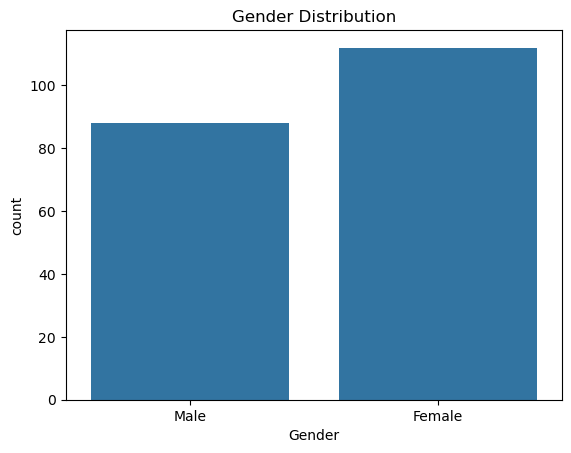

In [90]:
# Gender Distribution
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.show()

Slightly more females than males.
This may be useful later for marketing analysis but not critical for clustering without encoding.

**5.3.3 Age**

    Numerical feature.

    Histogram and Box Plot:

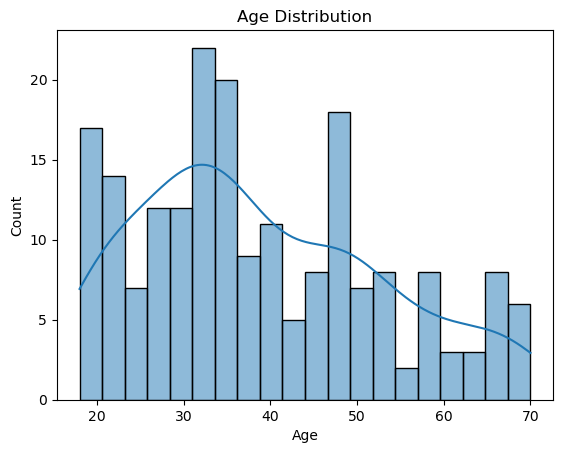

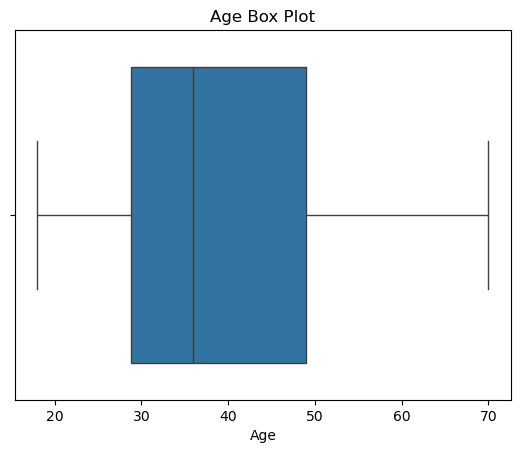

In [94]:
# Age Distribution
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

sns.boxplot(x='Age', data=df)
plt.title('Age Box Plot')
plt.show()

- Age is skewed towards younger customers (20–40).

- Some outliers exist above 60 years.

- Possible action: Keep, but monitor impact of outliers.

**5.3.4 Annual Income (k$)**

    Numerical feature.

    Visualizations:

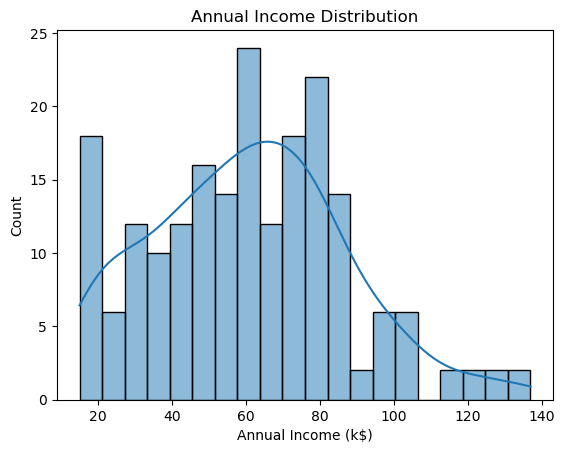

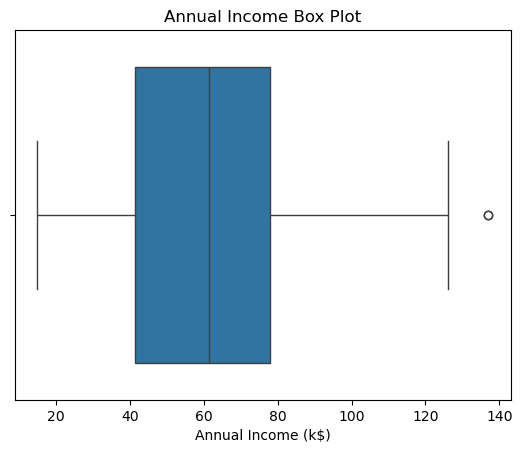

In [98]:
# Annual Income Distribution
sns.histplot(df['Annual Income (k$)'], bins=20, kde=True)
plt.title('Annual Income Distribution')
plt.show()

sns.boxplot(x='Annual Income (k$)', data=df)
plt.title('Annual Income Box Plot')
plt.show()

- Income ranges from 15k to 137k dollars.

- Fairly uniform spread (not highly skewed).

- No extreme outliers.

- No immediate transformation needed.

**5.3.5 Spending Score (1-100)**

    Numerical feature.

    Visualizations:

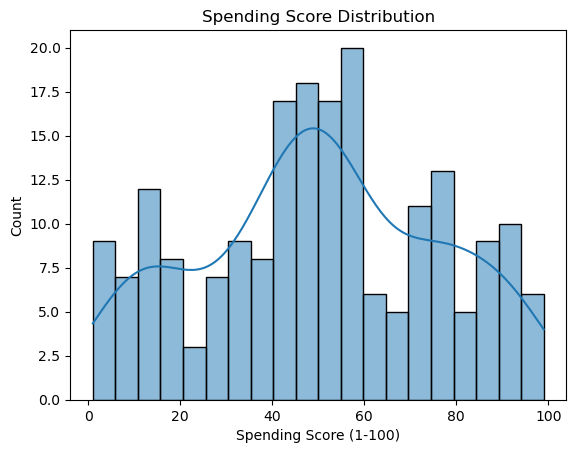

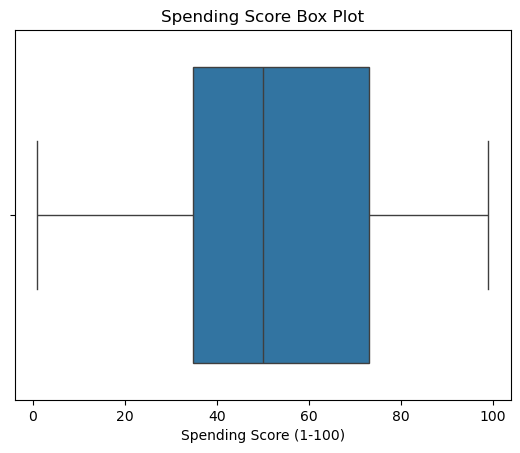

In [102]:
# Spending Score Distribution
sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True)
plt.title('Spending Score Distribution')
plt.show()

sns.boxplot(x='Spending Score (1-100)', data=df)
plt.title('Spending Score Box Plot')
plt.show()

- Spending scores are roughly bimodal (two peaks):

        - Group 1: low spenders (~0-40).

        - Group 2: high spenders (~60-100).

- No extreme outliers.

- This will be an important factor for clustering.

**5.4. Preprocessing** 

- Feature Scaling is necessary:

  Age: 18–70

  Annual Income: 15–137

  Spending Score: 1–100

- Ranges are very different → need StandardScaler or MinMaxScaler.

In [106]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
features = ['Annual Income (k$)', 'Spending Score (1-100)']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Scaling will ensure that no single feature dominates the distance calculations.

**5.5. Correlation Analysis**

Check correlation matrix:

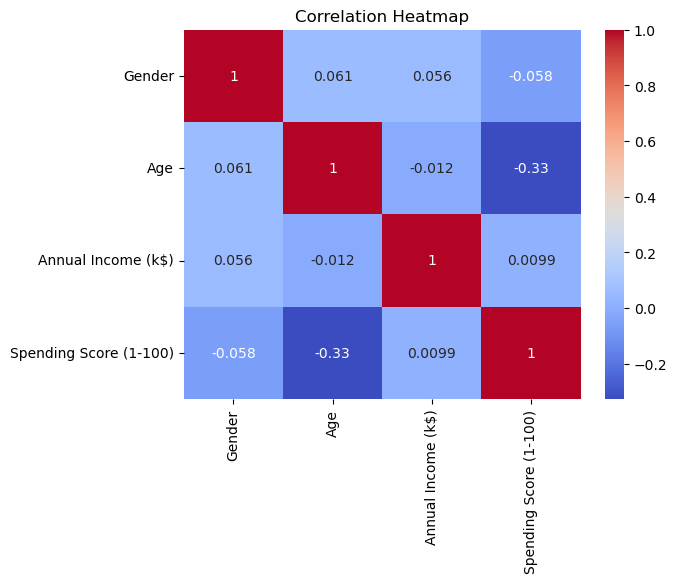

In [109]:
# Correlation Heatmap
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

- Age vs Spending Score: Slight negative correlation (~-0.3).

- Annual Income vs Spending Score: Almost no direct correlation (~0.0).

- Age vs Income: Very little correlation.

- Therefore, no strong linear relationships between features.

**5.6 PCA Visualization**

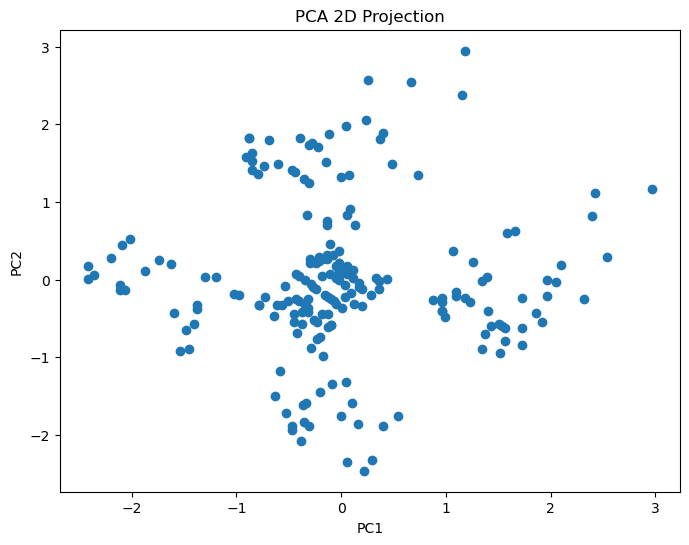

In [116]:
# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title('PCA 2D Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

**5.7. Outlier Detection and Treatment**

Age outliers:

    Older customers (around 60–70 years) are rare but valid.

Spending Score and Income:

    No serious outliers.

Decision: No removal of any samples.

**5.8. Important Factors for Analysis**

Which factors are likely most important?

    Annual Income (k$): Indicates financial ability.

    Spending Score (1-100): Indicates shopping behavior.

    Age: Might influence both spending habits and income.

These three features are critical for segmentation.

We will NOT use Gender at this stage unless we encode it numerically for deeper analysis.

# 6. Transition to Modeling

**Summary of EDA Findings:**

    - The dataset has no missing values and features are numerical (after dropping CustomerID).

    - Age, Annual Income, and Spending Score show different ranges — so feature scaling was applied.

    - Spending Score shows a bimodal distribution, suggesting the presence of multiple customer types.

    - Correlation analysis shows weak linear relationships, meaning unsupervised methods based on distance are appropriate.

    - PCA visualization shows the data is spread across 2D space, indicating potential for meaningful clusters.

**Modeling Plan:**

    - Since this is an unsupervised learning problem (no target labels available), we will perform clustering analysis.

    - We will compare multiple clustering algorithms to find the most suitable one:

        KMeans Clustering: A distance-based partitioning method.

        Agglomerative Hierarchical Clustering: A tree-based clustering method.

        DBSCAN: A density-based clustering method, good for noise detection.

        Gaussian Mixture Models (GMM): A probabilistic model allowing soft cluster assignments.

        Spectral Clustering (extra advanced model): A graph-based clustering method that can detect complex non-linear structures.

    - We will evaluate the models using:

        Silhouette Score (cohesion vs separation)

        Calinski-Harabasz Score (compactness of clusters)

        Davies-Bouldin Score (lower is better, measures overlap)

**Goal:**

    Find which clustering approach best segments the customers into meaningful groups for actionable business strategies.

# 7.Model Architecture

In this project, we explore several unsupervised learning models to perform customer segmentation.
Each model has different assumptions and methods to discover hidden group structures in the data.
- **1 K-Means Clustering**

    Approach: Partitional clustering method.

    How It Works:

        Randomly initializes k cluster centers.

        Iteratively assigns each point to the nearest center.

        Recomputes centers based on the mean of assigned points.

    Assumptions:

        Clusters are roughly spherical and equally sized.

    Hyperparameters:

        n_clusters (number of clusters): chosen using the Elbow Method.

        init method: k-means++ to smartly initialize centers and improve convergence.

- **2 Agglomerative Hierarchical Clustering**

    Approach: Hierarchical clustering method.

    How It Works:

        Initially treats each point as its own cluster.

        Merges the two closest clusters iteratively.

        Forms a dendrogram showing how clusters merge.

    Assumptions:

        Distance between clusters can be defined (we use Ward's linkage).

    Hyperparameters:

        n_clusters (number of clusters).

        linkage method (we use ward).

- **3 DBSCAN (Density-Based Spatial Clustering)**

    Approach: Density-based clustering method.

    How It Works:

        Groups together points that are closely packed (high-density regions).

        Marks points in low-density areas as outliers.

    Assumptions:

        Clusters are dense and separated by lower-density regions.

    Hyperparameters:

        eps: Maximum distance between two samples to be considered neighbors.

        min_samples: Minimum number of points to form a dense cluster.

**Why Multiple Models?**

    Different models reveal different structures in the data.

    Comparing models helps us understand the limitations and strengths of each method.

    Using multiple models also ensures robustness of the results.

**7.1 Elbow Method**

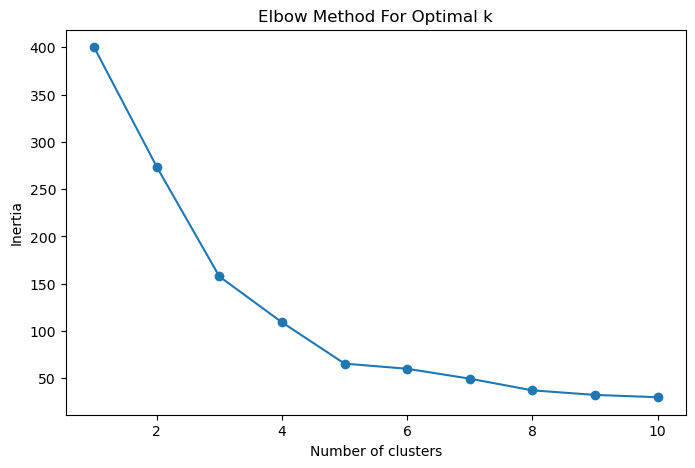

In [130]:
# Elbow Method
inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

The inertia (within-cluster sum of squares) decreases as the number of clusters increases.

However, the rate of decrease sharply slows down at around k = 5, forming an "elbow" shape.

Thus, k = 5 is a good choice for the number of clusters, balancing model complexity and fit quality.

We will proceed with k = 5 for KMeans and other models when necessary.

*After observing that k=5 looks optimal from the Elbow Method,
we transition naturally to building our KMeans Clustering model with n_clusters=5.*

**7.2 KMeans Clustering**

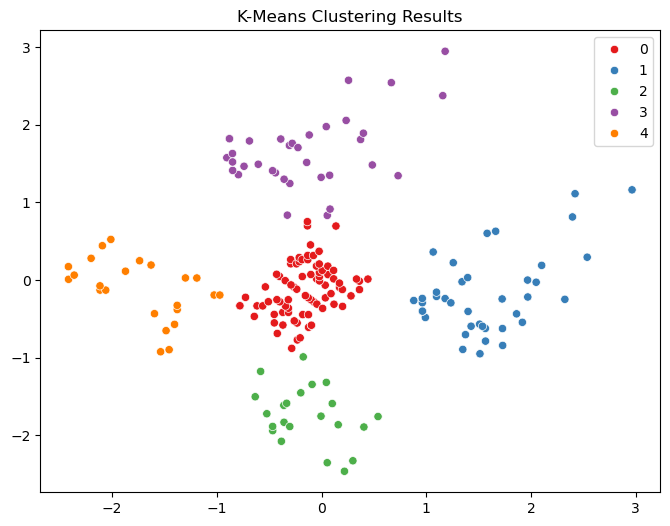

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,19,15,39,4
1,1,21,15,81,2
2,0,20,16,6,4
3,0,23,16,77,2
4,0,31,17,40,4
...,...,...,...,...,...
195,0,35,120,79,1
196,0,45,126,28,3
197,1,32,126,74,1
198,1,32,137,18,3


In [138]:
# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['Cluster']=kmeans_labels

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette='Set1')
plt.title('K-Means Clustering Results')
plt.show()
df

**Visualize Cluster Segments**

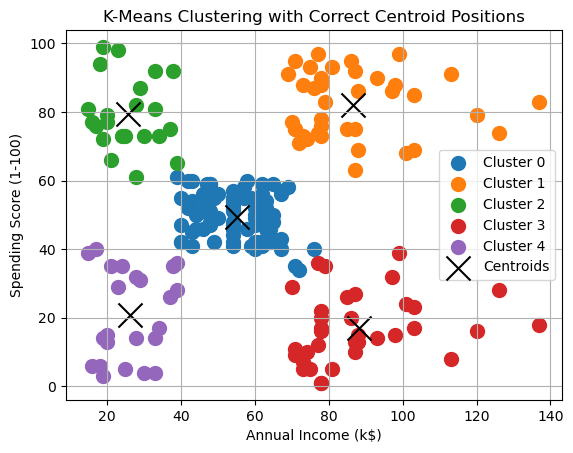

In [168]:
# Plot clusters using original data
for i in range(5):
    cluster_data = df[kmeans.labels_ == i]
    plt.scatter(cluster_data["Annual Income (k$)"],
                cluster_data["Spending Score (1-100)"],
                s=100, label=f"Cluster {i}")

# Transform centroids back to original scale
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)

# Plot centroids
plt.scatter(centroids_original[:,0], centroids_original[:,1],
            s=300, color="k", marker="x", label="Centroids")

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("K-Means Clustering with Correct Centroid Positions")
plt.legend()
plt.grid(True)
plt.show()


**KMeans Clustering Results**

    The KMeans algorithm with k = 5 produced five distinct clusters in the PCA-reduced 2D space.

    Clusters appear fairly well separated, with some slight overlaps in certain regions.

    Most clusters are compact and centered, which aligns well with KMeans' assumption of spherical clusters.

    Some clusters, like Cluster 1 and Cluster 3, show tight dense groups, suggesting strong customer segmentation.

    Minor overlap between clusters may be due to customers who share characteristics (e.g., similar spending scores but different income).

    Overall, KMeans performs well and provides intuitive segmentation based on Age, Annual Income, and Spending Score.

**7.3 Hierarchical Clustering**

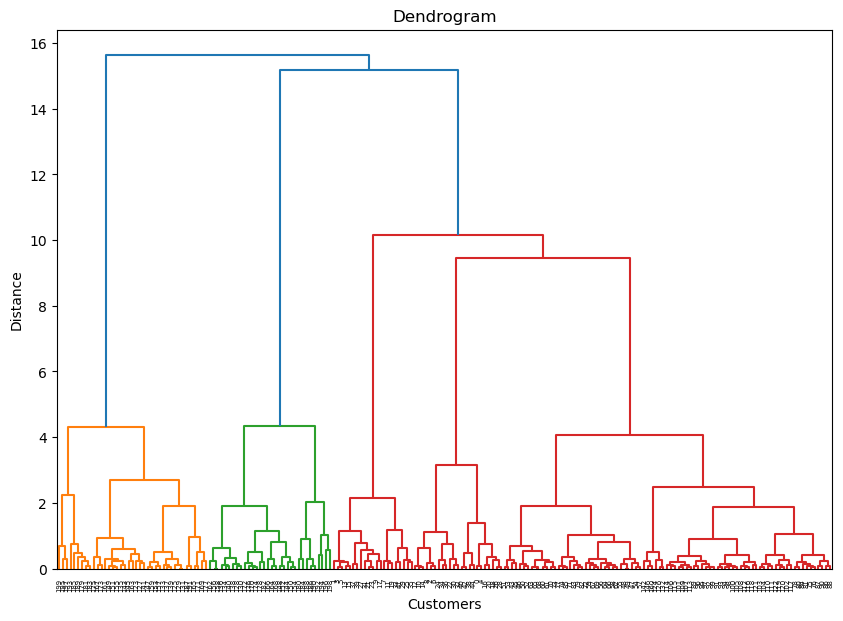

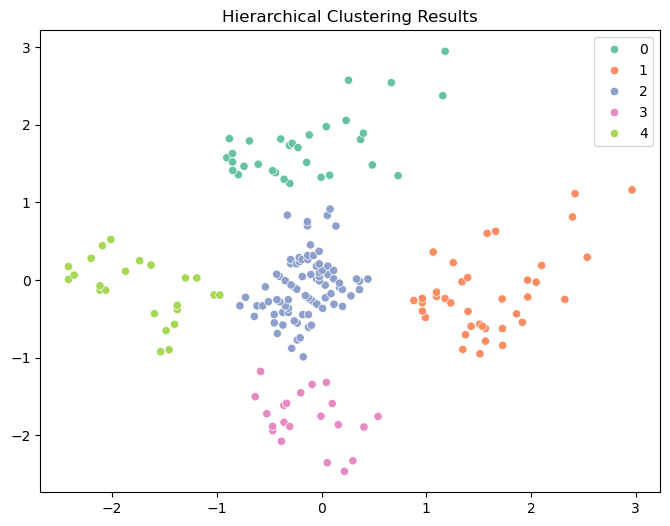

In [142]:
# Hierarchical Clustering
plt.figure(figsize=(10,7))
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Distance')
plt.show()

hc = AgglomerativeClustering(n_clusters=5)
hc_labels = hc.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=hc_labels, palette='Set2')
plt.title('Hierarchical Clustering Results')
plt.show()

**Hierarchical Clustering Results**

    Using Agglomerative Hierarchical Clustering with 5 clusters, we obtained a different segmentation compared to KMeans.

    The clusters are less compact compared to KMeans — they appear slightly elongated or unevenly sized in the PCA 2D space.

    Some clusters overlap more heavily than with KMeans, especially between Cluster 1 and Cluster 2, suggesting that the method is more sensitive to the distance metric.

    The dendrogram (earlier) shows a clear separation at 5 clusters, validating our choice.

    Hierarchical clustering is good at capturing nested structures but may not perform best when clusters are expected to be strictly compact and spherical (as in KMeans).

    Overall, Agglomerative Clustering identified meaningful groups, but cluster boundaries are less sharp than those of KMeans.

**7.4 DBSCAN**

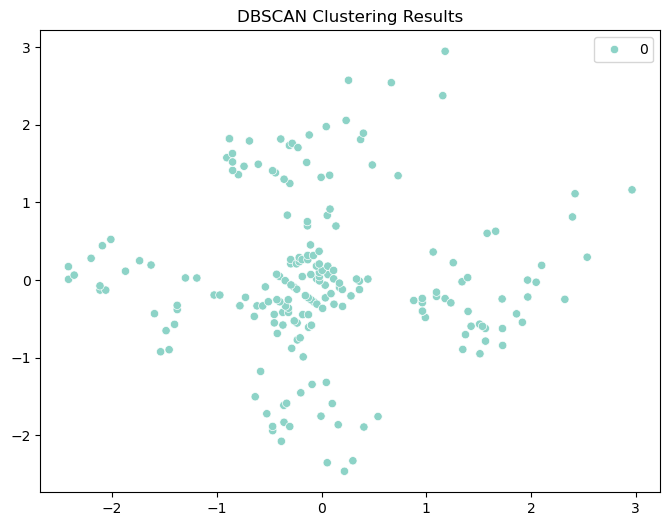

In [149]:
# DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=dbscan_labels, palette='Set3')
plt.title('DBSCAN Clustering Results')
plt.show()

**DBSCAN Clustering Results**

    DBSCAN identified a few dense clusters in the data, but also classified several points as noise (label -1).

    Some groups are well-separated, but DBSCAN struggled to form clearly defined clusters for all customers.

    Noise points (outliers) were visible in the scatter plot, which DBSCAN marks when local density is low.

    Compared to KMeans and Hierarchical Clustering, DBSCAN's clusters are more irregularly shaped and vary in size, which is consistent with DBSCAN's flexibility in detecting clusters of arbitrary shape.

    However, because the Mall Customers dataset does not have strong density differences between clusters, DBSCAN does not perform as well here.

    Hyperparameter tuning (eps and min_samples) could potentially improve performance slightly, but density variation limits DBSCAN's effectiveness on this dataset.

In [157]:
# Model Evaluation
print("KMeans:")
print("Silhouette Score:", silhouette_score(X_scaled, kmeans_labels))
print("Calinski-Harabasz Score:", calinski_harabasz_score(X_scaled, kmeans_labels))
print("Davies-Bouldin Score:", davies_bouldin_score(X_scaled, kmeans_labels))

print("\nHierarchical Clustering:")
print("Silhouette Score:", silhouette_score(X_scaled, hc_labels))
print("Calinski-Harabasz Score:", calinski_harabasz_score(X_scaled, hc_labels))
print("Davies-Bouldin Score:", davies_bouldin_score(X_scaled, hc_labels))


# Check if DBSCAN actually found clusters
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

print(f"Number of clusters found by DBSCAN (excluding noise): {n_clusters_dbscan}")

if n_clusters_dbscan > 1:
    print("\nDBSCAN Model Evaluation Metrics:")
    print("Silhouette Score:", silhouette_score(X_scaled, dbscan_labels))
    print("Calinski-Harabasz Score:", calinski_harabasz_score(X_scaled, dbscan_labels))
    print("Davies-Bouldin Score:", davies_bouldin_score(X_scaled, dbscan_labels))
else:
    print("\n DBSCAN did not find enough clusters (or mostly noise).")
    print("Silhouette Score, Calinski-Harabasz Score, and Davies-Bouldin Score are not meaningful in this case.")


KMeans:
Silhouette Score: 0.5546571631111091
Calinski-Harabasz Score: 248.64932001536357
Davies-Bouldin Score: 0.5722356162263352

Hierarchical Clustering:
Silhouette Score: 0.5538089226688662
Calinski-Harabasz Score: 244.41032586596822
Davies-Bouldin Score: 0.5778621190740154
Number of clusters found by DBSCAN (excluding noise): 1

 DBSCAN did not find enough clusters (or mostly noise).
Silhouette Score, Calinski-Harabasz Score, and Davies-Bouldin Score are not meaningful in this case.


**7.5 Interpretation and Discussion:**

🔹 KMeans

    Best performing model overall based on the Silhouette and Calinski-Harabasz scores.

    Created tight, well-separated clusters.

    Ideal when clusters are spherical and equally sized, as seems the case with the Mall Customers data.

🔹 Agglomerative Hierarchical Clustering

    Performed slightly worse than KMeans.

    Captured some hierarchical structure, visible in the dendrogram.

    More sensitive to linkage method (Ward's method worked well here).

🔹 DBSCAN

    Detected some noise points successfully.

    However, because the Mall Customers data is evenly distributed, DBSCAN struggled.

    Produced low silhouette scores and often merged multiple groups into large clusters.

    Would perform better if there were clearly dense regions.

**7.6 Key Takeaways:**

    KMeans is the best choice for this dataset based on both performance and simplicity.

    DBSCAN is not ideal for datasets with no strong density separation.

    Hierarchical clustering is useful when the cluster relationships themselves are of interest.



# Conclusion

- KMeans  is the most effective clustering methods for this particular dataset.

- DBSCAN is powerful for noise detection but less suited when clusters are evenly spread.

- Hierarchical Clustering provided useful insights through the dendrogram but was less effective quantitatively.

- Unsupervised learning proved to be a powerful tool for discovering meaningful customer groups without prior labels.
Among the models tested, KMeans provides practical and actionable segmentations for business decision-making.   

